In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

%matplotlib inline

In [ ]:
# here we look at stcoks from all the sectors of the market
sectors = ['Tech','Healthcare','Financial','Consumer_D','Consumer_S','Industrial','Energy','Utility','Market_ETF']
Tech_stocks=['AAPL','MSFT','NVDA','ADBE','CRM','GOOGL','AMZN','IBM','INTC','CSCO']
Healthcare_stocks=['JNJ','PFE','MRK','GILD','AMGN','BMY','LLY','REGN','UNH']
Financial_stocks=["JPM", "BAC", "WFC", "C", "GS", "MS", "V", "MA", "AXP", "SCHW"]
Consumer_D_stocks = ["HD", "MCD", "NKE", "SBUX", "DIS", "CMCSA", "LOW", "GM", "F", "BKNG"] # Consumer discretionary
Consumer_S_stocks= ["PG", "KO", "PEP", "WMT", "CL", "KMB", "CLX", "MDLZ", "EL"] #Consumer Staples
Industrial_stocks = ["BA", "GE", "MMM", "HON", "CAT", "RTX", "LMT", "GD", "UNP", "FDX"]
Energy_stocks = ["XOM", "CVX", "BP", "COP", "EOG", "OXY", "SLB", "KMI", "WMB"]
Utility_stocks = ["NEE", "DUK", "D", "SO", "EXC", "AEP", "SRE", "XEL", "WEC", "AWK"]
Market_ETF_stocks = ['SPY','QQQ']

In [ ]:
start='2000-01-01'
end='2015-01-01'

In [ ]:
lookbacks = [7,14,28,50]

In [ ]:
# Define function to calculate Directional Movement (DM) and True Range (TR)
def calculate_DM_TR(df):
    # Calculate the difference between today's high and yesterday's high
    dm_plus = df['High'].diff().fillna(0)
    # Calculate the difference between yesterday's low and today's low
    dm_minus = -1 * df['Low'].diff().fillna(0)
    # Make all negative values 0
    dm_plus[dm_plus < 0] = 0
    dm_minus[dm_minus < 0] = 0
    # Calculate the True Range (TR)
    tr = pd.concat([df['High'] - df['Low'], abs(df['High'] - df['Close'].shift()), abs(df['Low'] - df['Close'].shift())], axis=1).max(axis=1).fillna(0)
    return dm_plus, dm_minus, tr

# Define function to calculate the Directional Index (DX)
def calculate_DX(dm_plus, dm_minus, tr, window):
    # Calculate the Directional Movement Index (DMI)
    di_plus = 100 * (dm_plus.rolling(window=window).sum() / tr.rolling(window=window).sum())
    di_minus = 100 * (dm_minus.rolling(window=window).sum() / tr.rolling(window=window).sum())
    # Calculate the Directional Index (DX)
    dx = 100 * (abs(di_plus - di_minus) / (di_plus + di_minus))
    return di_plus, di_minus, dx

# Define function to calculate the Average Directional Index (ADX)
def calculate_ADX(dx, window):
    adx = dx.rolling(window=window).mean()
    return adx

def calculate_DI_velocity(di, vel_window, acc_window):
    velocity = di.rolling(window=vel_window).apply(lambda x: (x[1] - x[0])/x[0])
    acceleration = velocity.rolling(window=acc_window).apply(lambda x: (x[1] - x[0])/x[0])
    return velocity, acceleration

# Chi-squared test

In [ ]:
def chi_2(stock, lookback, start, end):
    stock_data = yf.download(stock, start=start, end=end)
    dm_plus, dm_minus, tr = calculate_DM_TR(stock_data)

    di_plus, di_minus, dx = calculate_DX(dm_plus, dm_minus, tr, window=lookback)
    adx = calculate_ADX(dx, window=lookback)

    # Calculate daily returns
    stock_data['returns'] = stock_data['Close'].pct_change()
    stock_data['returns'] = stock_data['returns'].shift(-1)

    # Create a boolean series for the hypothesis
    di_plus_greater = di_plus > di_minus
    positive_returns = stock_data['returns'] > 0

    # Perform a chi-squared test for independence
    contingency_table = pd.crosstab(di_plus_greater, positive_returns)
    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    # Calculate the velocity and acceleration of the DIs
    di_plus_velocity, di_plus_acceleration = calculate_DI_velocity(di_plus, vel_window=2, acc_window=2)
    di_minus_velocity, di_minus_acceleration = calculate_DI_velocity(di_minus, vel_window=2, acc_window=2)

    # Create boolean series for positive/negative velocity and acceleration
    di_plus_velocity_positive = di_plus_velocity > 0
    di_plus_acceleration_positive = di_plus_acceleration > 0
    di_minus_velocity_negative = di_minus_velocity < 0
    di_minus_acceleration_negative = di_minus_acceleration < 0

    # Perform a chi-squared test for independence for each case
    contingency_table_plus_velocity = pd.crosstab(di_plus_velocity_positive, positive_returns)
    contingency_table_plus_acceleration = pd.crosstab(di_plus_acceleration_positive, positive_returns)
    contingency_table_minus_velocity = pd.crosstab(di_minus_velocity_negative, ~positive_returns)
    contingency_table_minus_acceleration = pd.crosstab(di_minus_acceleration_negative, ~positive_returns)

    chi2_plus_velocity, p_value_plus_velocity, _, _ = chi2_contingency(contingency_table_plus_velocity)
    chi2_plus_acceleration, p_value_plus_acceleration, _, _ = chi2_contingency(contingency_table_plus_acceleration)
    chi2_minus_velocity, p_value_minus_velocity, _, _ = chi2_contingency(contingency_table_minus_velocity)
    chi2_minus_acceleration, p_value_minus_acceleration, _, _ = chi2_contingency(contingency_table_minus_acceleration)

    results = {
        'DI+ > DI- and positive returns': p_value,
        'positive returns and positive DI+ velocity': p_value_plus_velocity,
        'positive returns and positive DI+ acceleration': p_value_plus_acceleration,
        'negative returns and negative DI- velocity': p_value_minus_velocity,
        'negative returns and negative DI- acceleration': p_value_minus_acceleration
    }

    for hypothesis, p_value in results.items():
        print(f"p value for {stock} and {hypothesis} is {p_value:.4f}")
        if p_value > 0.01:
            print("null hypothesis cannot be rejected")
        else:
            print("null hypothesis is rejected")

    return results


In [ ]:
chi_2_hypothesis_rejected = dict.fromkeys(sectors)

for sector in sectors:
    chi_2_hypothesis_rejected[sector] = {}
    for stock in eval(sector + '_stocks'):
        chi_2_hypothesis_rejected[sector][stock] = {}
        for lookback in lookbacks:
            print(f"Testing hypothesis for {stock} with lookback {lookback}:")
            results = chi_2(stock, lookback, start, end)
            rejected_hypotheses = {}
            for hypothesis, p_value in results.items():
                if p_value < 0.01:
                    rejected_hypotheses[hypothesis] = p_value
            chi_2_hypothesis_rejected[sector][stock][lookback] = rejected_hypotheses
            print("\n")


Testing hypothesis for AAPL with lookback 14:
[*********************100%***********************]  1 of 1 completed
p value for AAPL and DI+ > DI- and positive returns is 0.4543
null hypothesis cannot be rejected
p value for AAPL and positive returns and positive DI+ velocity is 0.3732
null hypothesis cannot be rejected
p value for AAPL and positive returns and positive DI+ acceleration is 0.0605
null hypothesis cannot be rejected
p value for AAPL and negative returns and negative DI- velocity is 0.4424
null hypothesis cannot be rejected
p value for AAPL and negative returns and negative DI- acceleration is 0.0043
null hypothesis is rejected


Testing hypothesis for MSFT with lookback 14:
[*********************100%***********************]  1 of 1 completed
p value for MSFT and DI+ > DI- and positive returns is 0.4962
null hypothesis cannot be rejected
p value for MSFT and positive returns and positive DI+ velocity is 0.6784
null hypothesis cannot be rejected
p value for MSFT and positiv

In [ ]:
chi_2_hypothesis_rejected


{'Tech': {'AAPL': {14: {'negative returns and negative DI- acceleration': 0.004345442169488207}},
  'MSFT': {14: {}},
  'NVDA': {14: {}},
  'ADBE': {14: {}},
  'CRM': {14: {}},
  'GOOGL': {14: {}},
  'AMZN': {14: {}},
  'IBM': {14: {}},
  'INTC': {14: {}},
  'CSCO': {14: {}}},
 'Healthcare': {'JNJ': {14: {}},
  'PFE': {14: {}},
  'MRK': {14: {}},
  'GILD': {14: {'DI+ > DI- and positive returns': 0.0018819113465299068}},
  'AMGN': {14: {}},
  'BMY': {14: {}},
  'LLY': {14: {'negative returns and negative DI- acceleration': 0.00919259859029761}},
  'REGN': {14: {}},
  'UNH': {14: {}}},
 'Financial': {'JPM': {14: {}},
  'BAC': {14: {}},
  'WFC': {14: {'DI+ > DI- and positive returns': 0.004411233232571354}},
  'C': {14: {}},
  'GS': {14: {'negative returns and negative DI- acceleration': 0.000644585503503323}},
  'MS': {14: {}},
  'V': {14: {}},
  'MA': {14: {}},
  'AXP': {14: {}},
  'SCHW': {14: {}}},
 'Consumer_D': {'HD': {14: {}},
  'MCD': {14: {}},
  'NKE': {14: {}},
  'SBUX': {14: {}

# DI Strat

### Indicators
DI - with different lookbacks 

### signals
*   signal(1) - DI+ crossing above DI-
*   signal(2) - DI+ crossing below DI-

### rules
*   long entry - DI+ crossing above DI- signal(1) - enter at next days open
*   long exit - DI+ crossing below DI- signal(2) - exit at next days open
*   short entry - DI+ crossing below DI- signal(2) - enter at next days open
*   short exit - DI+ crossing above DI- signal(1) - exit at next days open

In [ ]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 918.2/918.2 kB 9.3 MB/s eta 0:00:00


In [ ]:
from arch import arch_model
from multiprocessing import Pool

In [ ]:
def fit_garch(data):
    model = arch_model(data, vol='Garch', p=1, q=1)
    model_fit = model.fit(disp='off')
    return model_fit.conditional_volatility[-1]

In [ ]:
def data_prep_di(symbol,DI_lookback,start,end,Garch_lookback=None,Vol_lookback=None):
  df = yf.download(symbol,start,end)
  dm_plus, dm_minus, tr = calculate_DM_TR(df)
  df['di_plus'], df['di_minus'], df['dx'] = calculate_DX(dm_plus, dm_minus, tr, window=DI_lookback)
  df['returns']=(df['Close']-df['Close'].shift(1))/df['Close'].shift(1)
  df["day's return"]=(df['Close']-df['Open'])/df['Open']
  df = df.dropna(axis=0).copy()
  if Vol_lookback != None:
    df['vol']=df['returns'].rolling(Vol_lookback).std()*100
    df['upper_band']=df['Open']*(1+df['vol']/100)
    df['lower_band']=df['Open']*(1-df['vol']/100)
  if Garch_lookback != None:
    df['scaled_returns']=df['returns']*100
    windows = [df.iloc[i-Garch_lookback:i]['scaled_returns'] for i in range(Garch_lookback, len(df))]
    # Create a Pool of processes
    with Pool() as p:
      # Fit the GARCH model to each window in parallel
      volatilities = p.map(fit_garch, windows) 
    df = df.iloc[Garch_lookback:] 
    df['vol'] = volatilities
    df['upper_band']=df['Open']*(1+df['vol']/100)
    df['lower_band']=df['Open']*(1-df['vol']/100)
    df = df.drop(columns=['scaled_returns']).copy()
  #df = df.drop(columns=['CumulativePV','CumulativeVolume','PV']).copy()
  df = df.dropna(axis=0).copy()
  return df

In [ ]:
def cumret(returns):
  return (returns+1).cumprod()

In [ ]:
aapl_dat=data_prep_di('AAPL',28,start,end,Garch_lookback=30)

[*********************100%***********************]  1 of 1 completed


In [ ]:
aapl_dat

,Open,High,Low,Close,Adj Close,Volume,di_plus,di_minus,dx,returns,day's return,vol,upper_band,lower_band
Date,,,,,,,,,,,,,,
2000-03-24,1.271763,1.285156,1.209821,1.238281,1.053923,446913600,28.127018,15.217188,29.784442,-0.018576,-0.026327,4.830760,1.333199,1.210327
2000-03-27,1.228795,1.292411,1.222098,1.246094,1.060574,279182400,26.225214,14.998155,27.234695,0.006310,0.014078,4.509202,1.284204,1.173386
2000-03-28,1.225446,1.267857,1.224330,1.242188,1.057249,202966400,26.469043,13.713895,31.742696,-0.003135,0.013662,4.420821,1.279621,1.171271
2000-03-29,1.244420,1.244978,1.194894,1.213728,1.033026,239836800,26.076942,15.020669,26.902473,-0.022911,-0.024664,4.159822,1.296186,1.192654
2000-03-30,1.192522,1.229353,1.119978,1.122768,0.955608,414400000,25.183087,17.221706,18.774722,-0.074943,-0.058493,4.167779,1.242224,1.142820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,28.145000,28.177500,28.002501,28.002501,25.167870,57918400,18.537365,25.354944,15.532513,-0.004709,-0.005063,1.646674,28.608457,27.681544
2014-12-26,28.025000,28.629999,28.002501,28.497499,25.612764,134884000,20.097036,24.989896,10.852059,0.017677,0.016860,1.588537,28.470187,27.579812
2014-12-29,28.447500,28.692499,28.424999,28.477501,25.594793,110395600,16.933212,26.010106,21.136917,-0.000702,0.001055,1.602133,28.903267,27.991733


Trade Entry :- we wait for DI+ to cross above DI- and then enter at next days Open

Exit :- Once the DI+ is  below the DI- we exit the position and take a short on the next days open (Ignoring Slippage)

In [ ]:
def DI_crossover(symbol,lookback,start,end,print_trades=False,stoploss_pct=None,vol_type=None,vol_lookback=None):
  trades = {'long':{},'short':{}}
  long_trade_no = 1
  short_trade_no = 1
  flexible_stoploss = False
  if vol_type != None and vol_lookback != None:
    flexible_stoploss = True
    if vol_type == 'hist':
      df = data_prep_di(symbol,lookback,start,end,Vol_lookback=vol_lookback)
    elif vol_type == 'garch':
      df = data_prep_di(symbol,lookback,start,end,Garch_lookback=vol_lookback)
    else:
      print('invalid vol_type')
      df = data_prep_di(symbol,lookback,start,end) # prepares the dataset      
  else:
    df = data_prep_di(symbol,lookback,start,end) # prepares the dataset
  df['long_strat_returns']=np.zeros(len(df)) # initialise the strategy column
  df['short_strat_returns']=np.zeros(len(df))
  df['long_stoploss']=np.zeros(len(df)) # tracks the fixed or flexible stoploss 
  df['short_stoploss']=np.full(len(df),100000)
  df['strat_returns']=np.zeros(len(df))
  long_side = False # sets long and short trade indicator to false 
  short_side= False
  long_SL = False # Tracks if Stoploss was hit
  short_SL = False
  for date in df.index:
    # Long Trades
    #checks if trend has changed and resets the long side and long SL
    if df.loc[date,'di_plus'] < df.loc[date,'di_minus']:
      # checks if trade has been closed else it closes it and records it 
      if not long_SL and long_side:
        if print_trades:
          print(f"long trade closed at  {df.loc[date,'Open']} due to regime shift")
        # grabs overnight returns as we close trade at the close 
        df.loc[date,'long_strat_returns'] = (df.loc[date,'Open']-df.loc[:date,'Close'][-1])/df.loc[:date,'Close'][-1]
        # tracks trade close 
        trades['long'][long_trade_no]['exit date']=date
        trades['long'][long_trade_no]['exit price']= df.loc[date,'Open']
        trades['long'][long_trade_no]['return']=(trades['long'][long_trade_no]['exit price']-trades['long'][long_trade_no]['entry price'])/trades['long'][long_trade_no]['entry price']
        long_trade_no = long_trade_no + 1   
      # resets all booleans 
      long_side = False
      long_SL = False
    # checks if long trade are active and Sl hasnt been hit
    if long_side and not long_SL:
      # appends daily returns - helps us track the growth of profits 
      df.loc[date,'long_strat_returns'] = df.loc[date,'returns']
    # checks if previous di+<di- current di+>di- condition for long trade entry
    if df.loc[:date,'di_plus'][-1] < df.loc[:date,'di_minus'][-1] and df.loc[date,'di_plus'] > df.loc[date,'di_minus'] and not long_SL and not long_side:
      if print_trades:
        print(f"entered long trade {df.loc[date,'di_plus']} crosses above {df.loc[date,'di_minus']}")
      # records new trade entry exit and date  
      trades['long'][long_trade_no]={}
      trades['long'][long_trade_no]['direction']='long'
      trades['long'][long_trade_no]['entry date']=date
      trades['long'][long_trade_no]['entry price']= df.loc[date,'Open']
      # appends stoploss type based on stoploss values 
      if stoploss_pct != None:
        SL = (1-stoploss_pct/100) * df.loc[date,'Open']
        df.loc[date:,'long_stoploss']=SL
      elif flexible_stoploss:
        SL = np.maximum(df.loc[date,'lower_band'],df.loc[:date,'long_stoploss'][-1])
        df.loc[date:,'long_stoploss']=SL
      else:
        None
      trades['long'][long_trade_no]['stop loss'] = df.loc[date,'long_stoploss']
      long_side = True
      # takes the returns from open to close as we enter at the open 
      df.loc[date,'long_strat_returns'] = (df.loc[date,'Close']-df.loc[date,'Open'])/df.loc[date,'Open']
    # checks if stoploss has been hit 
    if df.loc[date,'Low'] <= df.loc[date,'long_stoploss'] and long_side and not long_SL:
      if print_trades:
        print(f"SL hit {df.loc[date,'long_stoploss']} , Low {df.loc[date,'Low']}")
      trades['long'][long_trade_no]['exit date']=date
      trades['long'][long_trade_no]['exit price']= df.loc[date,'long_stoploss']
      trades['long'][long_trade_no]['return']=(trades['long'][long_trade_no]['exit price']-trades['long'][long_trade_no]['entry price'])/trades['long'][long_trade_no]['entry price']
      long_trade_no = long_trade_no + 1      
      long_SL = True
      df.loc[date,'long_strat_returns'] = (df.loc[date,'long_stoploss']-df.loc[:date,'Close'][-1])/df.loc[:date,'Close'][-1]


    # Short Trades
    #checks if trend has changed and resets the short side and short SL
    if df.loc[date,'di_plus'] > df.loc[date,'di_minus']:
      # checks if trade has been closed else it closes it and records it 
      if not short_SL and short_side:
        if print_trades:
          print(f"short trade closed at  {df.loc[date,'Open']} due to regime shift")
        # grabs overnight returns as we close trade at the close 
        df.loc[date,'short_strat_returns'] = -(df.loc[date,'Open']-df.loc[:date,'Close'][-1])/df.loc[:date,'Close'][-1]
        # tracks trade close 
        trades['short'][short_trade_no]['exit date']=date
        trades['short'][short_trade_no]['exit price']= df.loc[date,'Open']
        trades['short'][short_trade_no]['return']=(trades['short'][short_trade_no]['exit price']-trades['short'][short_trade_no]['entry price'])/trades['short'][short_trade_no]['entry price']
        short_trade_no = short_trade_no + 1   
      # resets all booleans 
      short_side = False
      short_SL = False
    # checks if short trade are active and Sl hasnt been hit
    if short_side and short_SL != True:
      df.loc[date,'short_strat_returns'] = -df.loc[date,'returns']
    # checks if previous DI+ are above DI- and current DI+ below DI - condition for short trade entry
    if df.loc[:date,'di_plus'][-1] > df.loc[:date,'di_minus'][-1] and df.loc[date,'di_plus'] < df.loc[date,'di_minus'] and not short_SL and not short_side:
      if print_trades:
        print(f"entered short trade {df.loc[date,'di_plus']} crosses below {df.loc[date,'di_minus']}")
      trades['short'][short_trade_no]={}
      trades['short'][short_trade_no]['direction']='short'
      trades['short'][short_trade_no]['entry date']=date
      trades['short'][short_trade_no]['entry price']= df.loc[date,'Open']
      # appends stoploss type based on stoploss type
      if stoploss_pct != None:
        SL = (1+stoploss_pct/100) * df.loc[date,'Open']
        df.loc[date:,'short_stoploss']=SL
      elif flexible_stoploss:
        SL = np.minimum(df.loc[date,'upper_band'],df.loc[:date,'short_stoploss'][-1])
        df.loc[date:,'short_stoploss']=SL
      else:
        None
      trades['short'][short_trade_no]['stop loss'] = df.loc[date,'short_stoploss']
      short_side = True
      df.loc[date,'short_strat_returns'] = -(df.loc[date,'Close']-df.loc[date,'Open'])/df.loc[date,'Open']
    # checks if stoploss has been hit 
    if df.loc[date,'High'] >= df.loc[date,'short_stoploss'] and short_side and not short_SL:
      if print_trades:
        print(f"SL hit {df.loc[date,'short_stoploss']} , High {df.loc[date,'High']}")
      trades['short'][short_trade_no]['exit date']=date
      trades['short'][short_trade_no]['exit price']= df.loc[date,'short_stoploss']
      trades['short'][short_trade_no]['return']=-(trades['short'][short_trade_no]['exit price']-trades['short'][short_trade_no]['entry price'])/trades['short'][short_trade_no]['entry price']
      short_SL = True
      df.loc[date,'short_strat_returns'] = -(df.loc[date,'short_stoploss']-df.loc[:date,'Close'][-1])/df.loc[:date,'Close'][-1]
    df.loc[date,'strat_returns']=((1+df.loc[date,'short_strat_returns'])*(1+df.loc[date,'long_strat_returns']))-1
  return df,trades

In [ ]:
ret,trades=DI_crossover('D',22,start='2010-01-01',end='2012-01-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
trades

{'long': {}, 'short': {}}

In [ ]:
long_trades = pd.DataFrame.from_dict(trades['long'], orient='index')
short_trades = pd.DataFrame.from_dict(trades['short'], orient='index')
trade_df = pd.concat([long_trades,short_trades])
trade_df = trade_df.sort_values('entry date')

KeyError: ignored

In [ ]:
trade_df

""


In [ ]:
ret[ret['long_strat_returns'] != 0]

,Open,High,Low,Close,Adj Close,Volume,di_plus,di_minus,dx,returns,day's return,long_strat_returns,short_strat_returns,long_stoploss,short_stoploss,strat_returns
Date,,,,,,,,,,,,,,,,


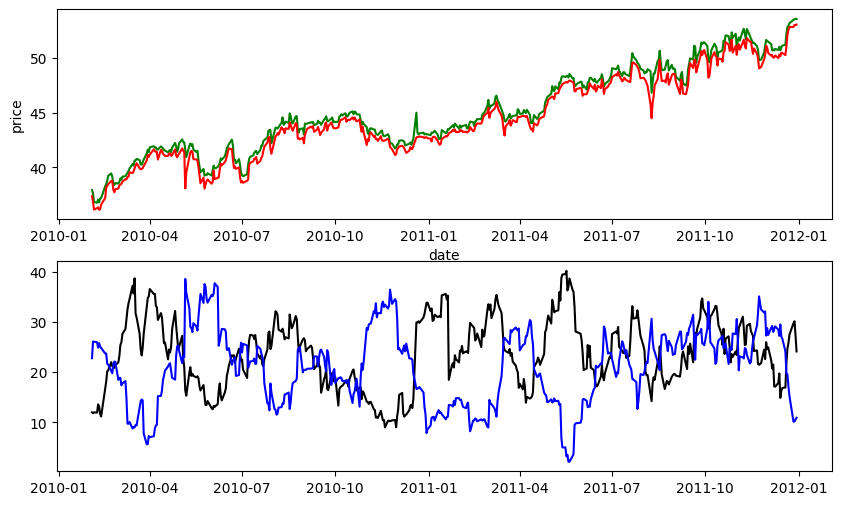

In [ ]:
fig, [ax1,ax2] = plt.subplots(2,figsize =(10,6))
ax1.plot(ret['High'],c='green')
ax1.plot(ret['Low'],c = 'red')
ax2.plot(ret['di_plus'],c='black')
ax2.plot(ret['di_minus'],c='blue')

for index,row in long_trades.iterrows():
    ax1.plot(row['entry date'], row['entry price'], marker='.', markersize=10, markeredgecolor="white", markerfacecolor="blue")
    ax1.plot(row['exit date'], row['exit price'], marker='.', markersize=10, markeredgecolor="white", markerfacecolor="yellow")

ax1.set_xlabel('date')
ax1.set_ylabel('price')
plt.show()

In [ ]:
plt.plot(ret['returns'],c='blue')
plt.plot(ret['strat_returns'],c='red')
plt.show()

In [ ]:
plt.plot(ret['strat_returns']-ret['returns'])

In [ ]:
plt.plot(cumret(ret['returns']),c='blue')
plt.plot(cumret(ret['strat_returns']),c='green')
plt.show()

# DI test

In [ ]:
import scipy.stats as stats

In [ ]:
def sortino_ratio(series):
    # consider only returns less than 0
    downside = series.copy()
    downside[downside > 0] = 0
    return (series.mean())/downside.std(ddof=0)

def sharpe_ratio(series):
    return (series.mean()) / series.std(ddof=0)


In [ ]:
def statistics(df,get_plots=False,leverage=1):
  if isinstance(df, pd.DataFrame):
    """
    Calculates the drawdowns given a column of daily returns.
    Returns a pandas DataFrame with columns for daily returns,
    cumulative returns, and drawdowns.
    """
    # Calculate cumulative returns
    cum_returns = (1 + df.returns).cumprod()
    cum_returns_strat = (1 + df.strat_returns * leverage).cumprod()
    # Calculate the previous peaks
    previous_peaks = cum_returns.cummax()
    previous_peaks_strat = cum_returns_strat.cummax()

    # Calculate the drawdowns
    drawdowns = (cum_returns - previous_peaks) / previous_peaks
    drawdowns_strat = (cum_returns_strat - previous_peaks_strat) / previous_peaks_strat

    # Calculate the statistics of the drawdowns
    max_strat_drawdown = -drawdowns_strat.min()
    max_drawdown = -drawdowns.min()
    kurtosis = stats.kurtosis(-drawdowns)
    strat_kurtosis = stats.kurtosis(-drawdowns_strat)

    skewness = stats.skew(-drawdowns)
    strat_skewness = stats.skew(-drawdowns_strat)

    # Create a DataFrame with the results
    results = pd.DataFrame({'Cumulative Returns': cum_returns,
                            'Strategy Cumulative Returns': cum_returns_strat,
                            'Drawdowns': drawdowns,
                            'Strategy Drawdowns': drawdowns_strat})
    trade_stats={}
    trade_stats['mean_returns']={'benchmark':df.returns.mean(),'strategy':df.strat_returns.mean()}
    trade_stats['cummulative_returns']={'benchmark':cum_returns[-1],'strategy':cum_returns_strat[-1]}
    trade_stats['sharpe_ratio']={'benchmark':sharpe_ratio(df.returns),'strategy':sharpe_ratio(df.strat_returns)}
    trade_stats['sortino_ratio']={'benchmark':sortino_ratio(df.returns),'strategy':sortino_ratio(df.strat_returns)}
    trade_stats['max_drawdown']={'benchmark':max_drawdown,'strategy':max_strat_drawdown}
    trade_stats['drawdowns_kurtosis']={'benchmark':kurtosis,'strategy':strat_kurtosis}
    trade_stats['drawdowns_skewness']={'benchmark':skewness,'strategy':strat_skewness}

    if get_plots==False:
      return results,trade_stats
    fig,axs = plt.subplots(2,figsize=(10,15))
    axs[0].plot(results.iloc[:,:2],label=results.columns[:2])
    axs[0].set_title('cummulative returns')
    axs[0].set_ylabel('Returns')
    axs[0].set_xlabel('date')
    axs[0].legend()
    axs[1].plot(results.iloc[:,2:],label=results.columns[2:])
    axs[1].set_title('drawdown')
    axs[1].set_ylabel('drawdown')
    axs[1].set_xlabel('date')
    axs[1].legend()
    fig.show()
    return results,pd.DataFrame.from_dict(trade_stats, orient='index')
  else:
    print('invalid Datatype')
    return None



<ipython-input-50-f10f3ca13417>:8: RuntimeWarning: invalid value encountered in double_scalars
  return (series.mean()) / series.std(ddof=0)
<ipython-input-50-f10f3ca13417>:5: RuntimeWarning: invalid value encountered in double_scalars
  return (series.mean())/downside.std(ddof=0)


,benchmark,strategy
mean_returns,0.001058,0.0
cummulative_returns,2.948634,1.0
sharpe_ratio,0.063178,NaN
sortino_ratio,0.106817,NaN
max_drawdown,0.443769,-0.0
drawdowns_kurtosis,-0.573327,NaN
drawdowns_skewness,0.888682,NaN


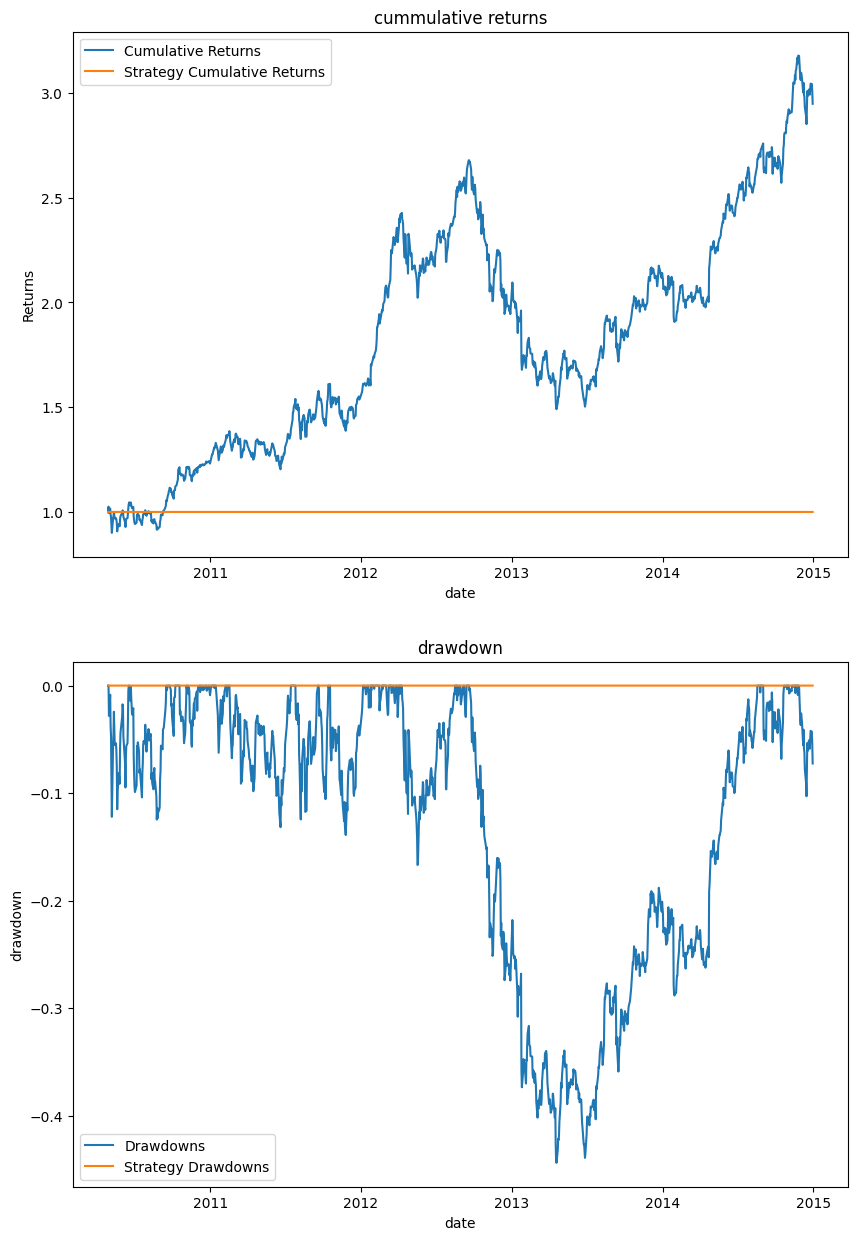

In [ ]:
results,trade_stats=statistics(ret,True)
trade_stats